In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.ticker as ticker
from PIL import Image
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

ModuleNotFoundError: No module named 'sklearn'

# Q1

a.

In [2]:
#讀取圖片資料並轉為dataframe
data_p = []
for i in range(1,41):
    for j in range(1,11):
        data_p.append(list(Image.open(f'C:/Users/USER/Desktop/Course/Data Analytics/DA05/ORL Faces/ORL Faces/{i}_{j}.png').getdata()))

data_p = pd.DataFrame(np.array(data_p))

#新增性別欄位，女性為0男性則為1
for i in data_p.index:
    if (i <= 9) | (70 <= i <= 79) | (90 <= i <= 99) | (310 <= i <= 319):
        data_p.loc[i, 'sex'] = 0
    else:
        data_p.loc[i, 'sex'] = 1
        
X = data_p.iloc[:,:-1]
y = data_p['sex']

In [182]:
#使用逐步迴歸篩選顯著像素
def stepwise_regression(X,y):
    #紀錄顯著的像素
    in_var = []
    
    while True:

        change = False
        
        #Forward selection : 
        out_var = list(set(X.columns)-set(in_var))
        
        #紀錄新像素之p-value
        new_x_pval = pd.Series(index=out_var)
        
        #對所有不在in_var的新像素進行迴歸並選出p-value最小的像素
        for x in out_var:
            model = sm.OLS(y, sm.add_constant(X.loc[:, in_var+[x]])).fit()
            new_x_pval[x] = model.pvalues[x]
        min_pval = new_x_pval.min()
        #若p-value小於0.01則加入in_var
        if min_pval <= 0.01:
            in_var.append(new_x_pval.idxmin())
            change = True

        #Backward selection :
        #對in_var所有像素進行迴歸並選出p-value最大者
        model = sm.OLS(y, sm.add_constant(X.loc[:, in_var])).fit()
        pval = model.pvalues[1:]
        max_pval = pval.max()
        
        #若p-value大於0.01則去除該像素
        if max_pval >= 0.01:
            in_var.remove(pval.idxmax())
            change = True
        
        #若加入的新像素不夠顯著或in_var中無不顯著的像素則終止迴圈
        if not change:
            break
    
    return in_var        

significant_pixels = stepwise_regression(X,y) 

X_s = data_p[significant_pixels]

In [225]:
#stepwise regression
ols = LinearRegression()
ols.fit(X_s, y)
y_pred_sr = ols.predict(X_s)
mse_sr = mean_squared_error(y, y_pred_sr)

#Ridge regression
ridge_cv = RidgeCV(alphas=[t for t in np.arange(1e-5, 1, 0.01)], cv=5)
ridge_cv.fit(X, y)
y_pred_r = ridge_cv.predict(X)
mse_r = mean_squared_error(y, y_pred_r)

#LASSO regression
lasso_cv = LassoCV(alphas=[t for t in np.arange(1e-5, 1, 0.01)], cv=5)
lasso_cv.fit(X, y)
y_pred_l = lasso_cv.predict(X)
mse_l = mean_squared_error(y, y_pred_l) 

In [226]:
print(f"MSE of stepwise regression is {mse_sr}")
print()
print(f"MSE of Ridge regression is {mse_r}")
print()
print(f"MSE of LASSO regression is {mse_l}")

MSE of stepwise regression is 0.012474149409729338

MSE of Ridge regression is 3.0289602143414327e-23

MSE of LASSO regression is 0.03982085228233607


b.

In [227]:
non_zero_params = []
for i in range(len(lasso_cv.coef_)):
    if lasso_cv.coef_[i] != 0:
        non_zero_params.append(i)  

Text(0.5, 1.0, 'Pixel chosen by Lasso')

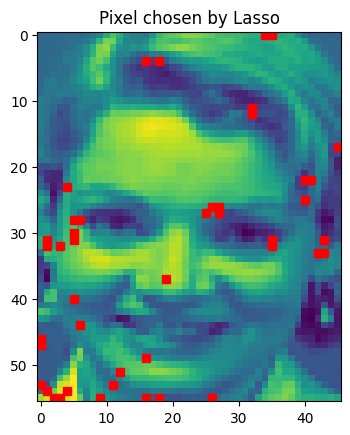

In [232]:
#pixel from LASSO
plt.imshow(img)
for pixel in non_zero_params:
    plt.plot(pixel%46, pixel//46, 'rs')
plt.title('Pixel chosen by Lasso')

# Q2

a.

In [59]:
data_v = pd.read_csv('C:/Users/USER/Desktop/Course/Data Analytics/DA05/DA HW05.csv', index_col='Year ')
data_v = np.log(data_v)
X_v = data_v[['Capital ','Labor ']]
y_v = data_v['Value Added ']

In [60]:
X_v = sm.add_constant(X_v)
ols = sm.OLS(y_v,X_v)
results = ols.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           Value Added    R-squared:                       0.817
Model:                            OLS   Adj. R-squared:                  0.786
Method:                 Least Squares   F-statistic:                     26.78
Date:                Sun, 02 Apr 2023   Prob (F-statistic):           3.76e-05
Time:                        17:45:02   Log-Likelihood:                 19.196
No. Observations:                  15   AIC:                            -32.39
Df Residuals:                      12   BIC:                            -30.27
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -9.6745      2.907     -3.328      0.0

b.

In [61]:
ols_glm = sm.GLM(y_v, X_v)
results = ols_glm.fit_constrained(([0,1,1],1)) #add contraint of b1+b2=1
print(results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:           Value Added    No. Observations:                   15
Model:                            GLM   Df Residuals:                       13
Model Family:                Gaussian   Df Model:                            1
Link Function:               identity   Scale:                       0.0064940
Method:                          IRLS   Log-Likelihood:                 17.566
Date:                Sun, 02 Apr 2023   Deviance:                     0.084422
Time:                        17:45:09   Pearson chi2:                   0.0844
No. Iterations:                     1   Pseudo R-squ. (CS):             0.9478
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.7126      0.021   -225.980      0.0

# Q3

a.

In [5]:
def PCA_func(X=None, isCorrMX=False):
    n = len(X) # sample size
    p = len(X.columns) # number of variables
    X = (np.eye(n)-np.ones((n,n))/int(n)) @ X # center X
    Z = X / np.std(X, axis=0)
    
    S = np.cov(X,rowvar=False)
    R = np.corrcoef(X,rowvar=False)
    
    if isCorrMX == True:
         eig_vals, eig_vecs = np.linalg.eig(R)
    else:
         eig_vals, eig_vecs = np.linalg.eig(S)

    P = eig_vecs # loading matrix 
    eigenvalues = list(np.real(eig_vals))
    eigenvector = eig_vecs
    if isCorrMX == True:
         T = np.dot(Z,P) # score matrix
    else:
         T = np.dot(X,P)

    #Scree plot
    fig, ax1 = plt.subplots(figsize=(8,5))

    PC = pd.Series({f"PC{i+1}":eigenvalues[i] for i in range(p)}) # Variance of each pc
    ax1.bar(PC.keys(), PC.values, width=0.5, align='center', 
            label='Variance of Principal Component')
    ax1.set_title('Scree Plot with Variance Explained')
    ax1.set_xlabel('Principal Component')
    ax1.set_ylabel('Variance')
    if len(PC.keys()) > 10:
        ax1.xaxis.set_major_locator(ticker.MultipleLocator(500))
    
    ax2 = ax1.twinx()
    variance_ratio = np.cumsum(PC) / np.sum(PC)
    ax2.plot(PC.keys(), variance_ratio, 'o-', linewidth=2, c='r', 
             label='Cumulative Percentage of Variance Explained')
    ax2.set_ylabel('Cumulative Percentage(%)')
    ax2.set_ylim(0, 1)
    ax2.yaxis.set_major_formatter(ticker.PercentFormatter(1.0))
   
    fig.legend(loc='center', fontsize=12, shadow=True)

    return P, eigenvalues, eigenvector, T

b.

In [27]:
data_a = pd.read_csv('C:/Users/USER/Desktop/Course/Data Analytics/DA05/auto-mpg.data.csv')
data_a = data_a[data_a['horsepower'] != '?']
data_a['horsepower'] = data_a['horsepower'].astype(float)
auto_mpg = data_a.iloc[:,1:-1]

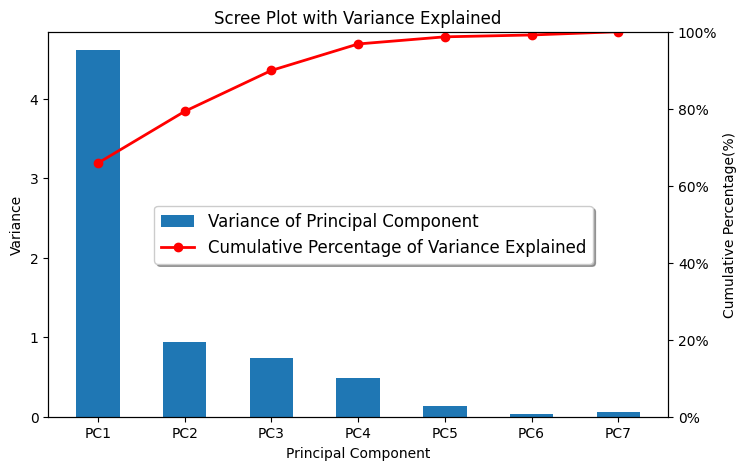

In [28]:
#Use correlation matrix
loading_matrix_R, eigenvalue_R ,eigenvector_R, score_matrix_R = PCA_func(auto_mpg, isCorrMX=True)

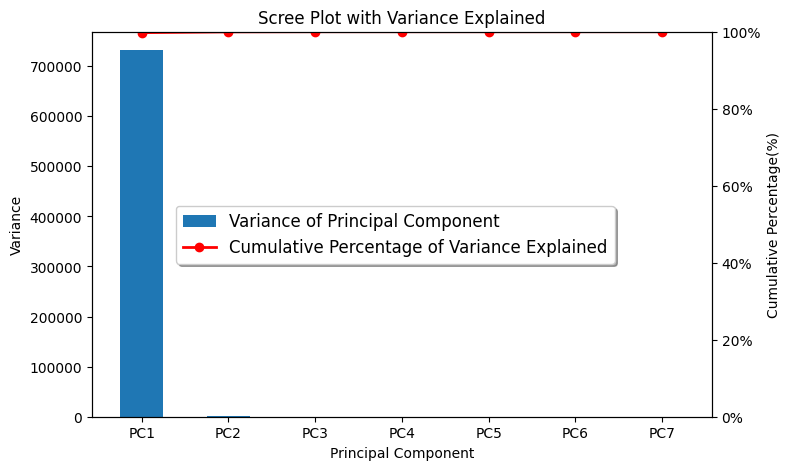

In [29]:
#Use covariance matrix
loading_matrix_S, eigenvalue_S ,eigenvector_S, score_matrix_S = PCA_func(auto_mpg, isCorrMX=False)

# Q4

a.

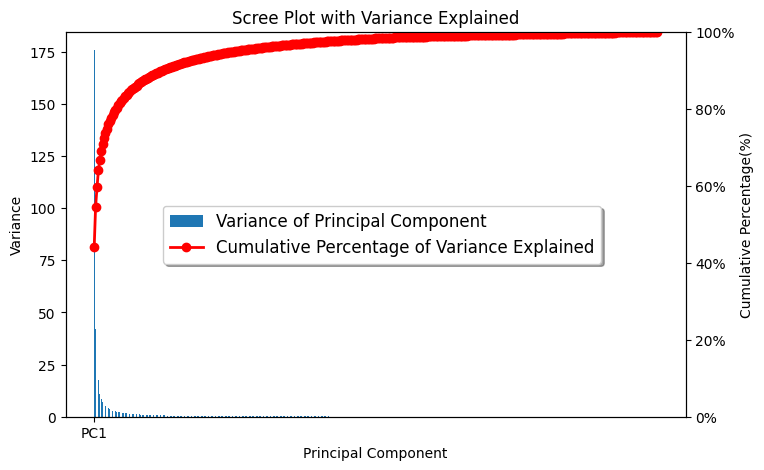

In [6]:
loading_matrix, eigenvalues ,eigenvectors, score_matrix = PCA_func(X.T, isCorrMX=True)

In [7]:
PC = pd.Series({f"PC{i+1}":eigenvalues[i] for i in range(400)}) 
variance_ratio = np.cumsum(PC) / np.sum(PC)
for ratio in [0.5,0.6,0.7,0.8,0.9]:
    pc_size = len(variance_ratio[variance_ratio.values <= ratio])+1
    print(f"{pc_size} principal components are needed to explain {ratio*100:.0f}% of total variance")
    print()

2 principal components are needed to explain 50% of total variance

4 principal components are needed to explain 60% of total variance

7 principal components are needed to explain 70% of total variance

17 principal components are needed to explain 80% of total variance

50 principal components are needed to explain 90% of total variance



b.

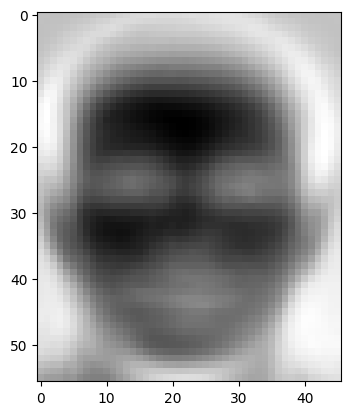

In [15]:
PC1 =  score_matrix[:, 0]
rescaled_PC1 = (PC1 - np.min(PC1)) / (np.max(PC1) - np.min(PC1)) * 255
PC1_matrix = PC1.reshape((56, 46))
plt.imshow(PC1_matrix, cmap='gray')
plt.show()